In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
from os import path

In [3]:
import tabint as tb
from tabint.pre_processing import *
from tabint.dataset import *
from tabint.learner import *
from tabint.feature import *
from tabint.interpretation import *

In [4]:
file_path = '/media/zero/dropbox/Dropbox/Data science project/kaggle/home_credit_default_risk/data/'

In [5]:
app_train = pd.read_csv(file_path + 'application_train.csv')

In [6]:
app_train_proc, y, pp_outp = tabular_proc(app_train, 'TARGET', [fill_na(), app_cat(), dummies()])

In [7]:
cons = pp_outp['cons']; cats = pp_outp['cats']

In [8]:
impt_ft = [['EXT_SOURCE_3'], ['EXT_SOURCE_2'], ['AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY'], ['EXT_SOURCE_1'], ['DAYS_BIRTH'], ['DAYS_EMPLOYED'], ['DAYS_ID_PUBLISH'], ['CODE_GENDER_F'], ['NAME_EDUCATION_TYPE_Higher education'], ['FLAG_OWN_CAR_N', 'OWN_CAR_AGE'], ['EXT_SOURCE_1_na'], ['CODE_GENDER_M'], ['NAME_FAMILY_STATUS_Married'],  ['DAYS_LAST_PHONE_CHANGE'], ['NAME_CONTRACT_TYPE_Cash loans'], ['AMT_REQ_CREDIT_BUREAU_HOUR_na', 'AMT_REQ_CREDIT_BUREAU_DAY_na', 'AMT_REQ_CREDIT_BUREAU_WEEK_na', 'AMT_REQ_CREDIT_BUREAU_MON_na', 'AMT_REQ_CREDIT_BUREAU_QRT_na', 'AMT_REQ_CREDIT_BUREAU_YEAR_na'], ['OCCUPATION_TYPE'], ['NAME_EDUCATION_TYPE_Secondary / secondary special'], ['REG_CITY_NOT_LIVE_CITY'], ['ORGANIZATION_TYPE'], ['DAYS_REGISTRATION'], ['NAME_INCOME_TYPE_Working'], ['FLAG_DOCUMENT_13'], ['FLAG_WORK_PHONE'], ['FLAG_DOCUMENT_16'], ['OWN_CAR_AGE_na']]

In [9]:
cons = [i for i in cons if i in flat_list(impt_ft)]
cats = [i for i in cats if i in flat_list(impt_ft)]

In [10]:
app_train_proc = app_train_proc[flat_list(impt_ft)]

In [11]:
ds = TBDataset.from_TBSplit(app_train_proc, y, cons, cats)

In [12]:
tfs = {'drop 1': ['AMT_REQ_CREDIT_BUREAU_HOUR_na', 'AMT_REQ_CREDIT_BUREAU_DAY_na',
                  'AMT_REQ_CREDIT_BUREAU_WEEK_na', 'AMT_REQ_CREDIT_BUREAU_MON_na',
                  'AMT_REQ_CREDIT_BUREAU_QRT_na', 'AMT_REQ_CREDIT_BUREAU_YEAR_na'],
    
        'apply':{'DAYS_BIRTH': lambda df: -df['DAYS_BIRTH']/365,
                 'DAYS_EMPLOYED': lambda df: -df['DAYS_EMPLOYED']/365,
                 'DAYS_ID_PUBLISH': lambda df: -df['DAYS_ID_PUBLISH']/365,
                 'DAYS_LAST_PHONE_CHANGE': lambda df: -df['DAYS_LAST_PHONE_CHANGE']/365,
                 'DAYS_REGISTRATION': lambda df: -df['DAYS_REGISTRATION']/365,
                 
                 'NEW_EXT_SOURCES_MEAN': lambda df: df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True),
                 'NEW_EXT_SOURCES_GEO': lambda df: (df['EXT_SOURCE_1']*df['EXT_SOURCE_2']*df['EXT_SOURCE_3'])**(1/3),
                 
                 'AMT_CREDIT/AMT_GOODS_PRICE': lambda df: df['AMT_CREDIT']/df['AMT_GOODS_PRICE'],
                 'AMT_CREDIT/AMT_CREDIT': lambda df: df['AMT_CREDIT']/df['AMT_CREDIT'],
                 
                 'DAYS_EMPLOYED/DAYS_BIRTH': lambda df: df['DAYS_EMPLOYED']/df['DAYS_BIRTH'],
                 'DAYS_BIRTH*EXT_SOURCE_1_na': lambda df: df['DAYS_BIRTH']*df['EXT_SOURCE_1_na']},
    
        'drop 2': ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE']}

In [13]:
ds.transform(tfs)

In [14]:
ds.keep(['DAYS_BIRTH', 'DAYS_ID_PUBLISH'])

# learner

In [15]:
learner = SKLearner(RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False))

In [16]:
learner.fit(*ds.trn, *ds.val)

trn accuracy:  0.9190514129621801
val accuracy:  0.9201502365738257


# plot

In [17]:
dt = DrawTree.from_SKLearn(learner, ds)

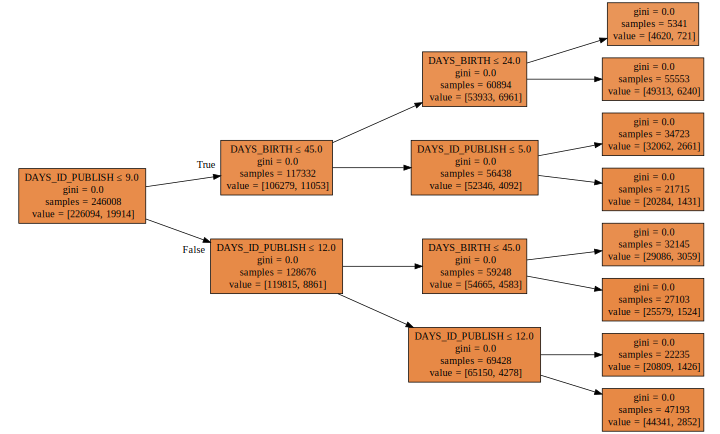

In [18]:
dt.plot()

why split at DAYS_BIRTH = 45???@@

# DAYS_ID_PUBLISH

In [19]:
kde = KernelDensityEstimation.from_series(ds.y_trn, 'DAYS_ID_PUBLISH', ds.x_trn.DAYS_ID_PUBLISH.values)

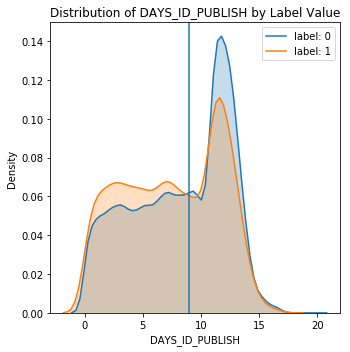

In [20]:
kde.plot(vline=9)

In [21]:
x = ds.x_trn.DAYS_ID_PUBLISH.values
y = ds.y_trn.values

In [22]:
sort_idx = np.argsort(x)
sort_y,sort_x = y[sort_idx], x[sort_idx]

[<matplotlib.lines.Line2D at 0x7febd0992b00>]

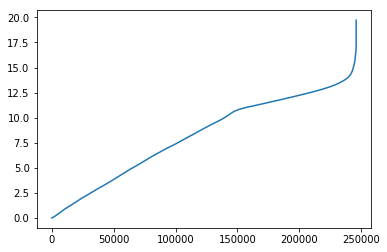

In [23]:
plt.plot(sort_x)

In [24]:
min_leaf = 3

In [25]:
rhs_cnt,rhs_sum,rhs_sum2 = len(x), sort_y.sum(), (sort_y**2).sum()
lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.
score = float('inf')

In [26]:
scores = []
xs = []

In [27]:
for i in range(1,len(x)-min_leaf-1):
    xi = sort_x[i]
    yl, yr = sort_y[:i], sort_y[i:]
    
    l_len, r_len = len(yl), len(yr)
    
    xi,yi = sort_x[i],sort_y[i]
    lhs_cnt += 1; rhs_cnt -= 1
    lhs_sum += yi; rhs_sum -= yi
    lhs_sum2 += yi**2; rhs_sum2 -= yi**2
    if i<min_leaf or xi==sort_x[i+1]: continue
        
    l_gini = 1-((yl==1).sum()/l_len)**2 - ((yl==0).sum()/l_len)**2
    r_gini = 1-((yr==1).sum()/r_len)**2 - ((yr==0).sum()/r_len)**2
    curr_score = l_gini*l_len + r_gini*r_len    
    scores.append(curr_score)
    xs.append(xi)
    if curr_score<score: score, split = curr_score,xi

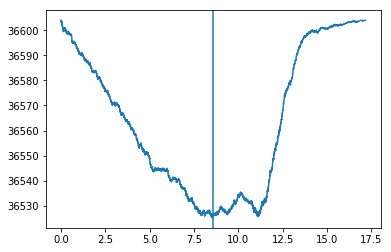

In [28]:
plt.plot(xs, scores)
plt.axvline(split)

# DAYS_BIRTH

In [370]:
class KernelDensityEstimation(BaseViz):
    def __init__(self, data, label_uniques, label_values, col_names, col_values, bins):
        self.data = data
        self.label_uniques, self.label_values = label_uniques, label_values
        self.col_names, self.col_values = col_names, col_values
        self.bins = bins

    @classmethod
    def from_df(cls, df, label_name, col_names, bins = 50):
        label_values = df[label_name].values
        col_values, col_names = to_iter(df[col_names].T.values), to_iter(col_names)
        label_uniques = np.unique(label_values)
        data = cls.calculate(label_uniques, label_values, col_names, col_values, bins)
        return cls(data, label_uniques, label_values, col_names, col_values, bins)

    @classmethod
    def from_series(cls, label_values, col_names, col_values, bins = 50):
        label_uniques = np.unique(label_values)
        col_names, col_values = to_iter(col_names), to_iter(col_values)
        data = cls.calculate(label_uniques, label_values, col_names, col_values, bins)
        return cls(data, label_uniques, label_values, col_names, col_values, bins)
    
    @staticmethod
    def calculate(label_uniques, label_values, col_names, col_values, bins):
        data = pd.DataFrame(columns=['col name', 'division', 'label value', 'count'])
        for col_name, col_value in zip(col_names, col_values):
            for label in label_uniques:
                count, division = cal_histogram(na_rm(col_value[label_values == label]), bins)
                data = pd_append(data, [col_name]*bins, division, [label]*bins, count)
        return data
        
    def plot(self, bins = None, vline = None, **kargs):
        for col_name, col_value in zip(self.col_names, self.col_values):
            plot_kde2(self.label_uniques, self.label_values, col_name, col_value, gridsize = bins or self.bins, vline = vline, **kargs)

In [371]:
def plot_kde2(label_uniques, label_values, col_name, col_value, vline = None, figsize = None, shade = True, gridsize=100):
    if figsize is None: figsize = (5, 5)
    plt.figure(figsize = figsize)
    for label in label_uniques: 
        sns.kdeplot(col_value[label_values == label], shade=shade, label = 'label: ' + str(label), gridsize = gridsize)
    if vline is not None: plt.axvline(vline)
    plt.title('Distribution of %s by Label Value' % col_name)
    plt.xlabel('%s' % col_name)
    plt.ylabel('Density')
    plt.tight_layout(h_pad = 2.5)

In [30]:
#begin with days birth
kde = KernelDensityEstimation.from_series(ds.y_trn, 'DAYS_BIRTH', ds.x_trn.DAYS_BIRTH.values)

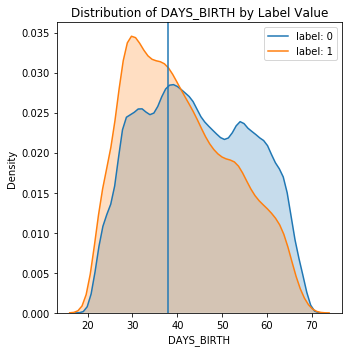

In [41]:
kde.plot(vline=38)

In [32]:
x = ds.x_trn.DAYS_BIRTH.values
y = ds.y_trn.values

In [33]:
sort_idx = np.argsort(x)
sort_y,sort_x = y[sort_idx], x[sort_idx]

[<matplotlib.lines.Line2D at 0x7febd842e588>]

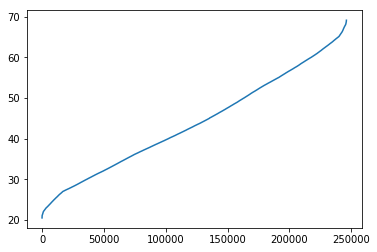

In [34]:
plt.plot(sort_x)

In [35]:
min_leaf = 3

In [36]:
rhs_cnt,rhs_sum,rhs_sum2 = len(x), sort_y.sum(), (sort_y**2).sum()
lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.
score = float('inf')

In [37]:
scores = []
xs = []

In [38]:
for i in range(1,len(x)-min_leaf-1):
    xi = sort_x[i]
    yl, yr = sort_y[:i], sort_y[i:]
    
    l_len, r_len = len(yl), len(yr)
    
    xi,yi = sort_x[i],sort_y[i]
    lhs_cnt += 1; rhs_cnt -= 1
    lhs_sum += yi; rhs_sum -= yi
    lhs_sum2 += yi**2; rhs_sum2 -= yi**2
    if i<min_leaf or xi==sort_x[i+1]: continue
        
    l_gini = 1-((yl==1).sum()/l_len)**2 - ((yl==0).sum()/l_len)**2
    r_gini = 1-((yr==1).sum()/r_len)**2 - ((yr==0).sum()/r_len)**2
    curr_score = l_gini*l_len + r_gini*r_len    
    scores.append(curr_score)
    xs.append(xi)
    if curr_score<score: score, split = curr_score,xi

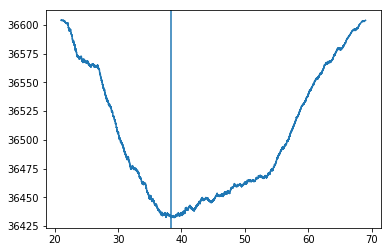

In [39]:
plt.plot(xs, scores)
plt.axvline(split)

In [40]:
split

38.345205479452055